In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import io

# import seaborn as sns

In [2]:
# Chemin vers votre fichier Excel
file_path = 'Online Retail.xlsx'
# Chargement du fichier Excel dans un DataFrame
with io.open(file_path, 'r', encoding='utf-8') as f:
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        # Affichez les premières lignes pour vérifier si le chargement s'est bien déroulé
        print(df.head())
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier Excel : {e}")


# Affichage des premières lignes du DataFrame

#print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
# Filtrage des lignes avec des quantités négatives
negative_quantities = df[df['Quantity'] < 0]

# Affichage des premières lignes avec des quantités négatives
print(negative_quantities.head())

    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
La colonne 'motif' n'existe pas dans le fichier.


C:\Users\steph\AppData\Local\Temp\ipykernel_7148\2784641388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_quantities['InvoiceDate'] = pd.to_datetime(
Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1599, in _readerthread


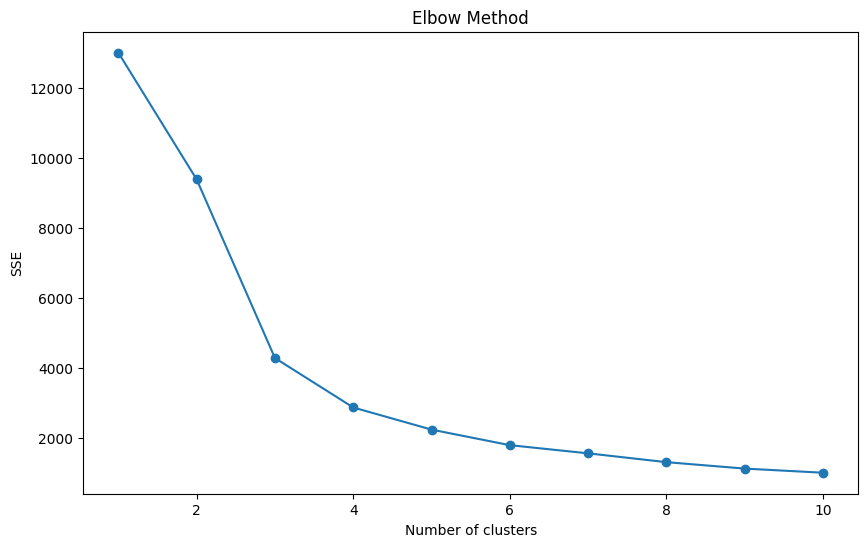

In [3]:
positive_quantities = df[df['Quantity'] >= 0]
positive_quantities['InvoiceDate'] = pd.to_datetime(
    positive_quantities['InvoiceDate'])
# Calcul de la récence, fréquence et montant
reference_date = pd.to_datetime('2010-12-01')
rfm = positive_quantities.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'CustomerID': 'count',
    'UnitPrice': 'sum',
}).rename(columns={
    'InvoiceDate': 'Recency',
    'CustomerID': 'Frequency',
    'UnitPrice': 'Monetary'
}).reset_index()

# Préparer les données pour le clustering
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardiser les données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)
# Déterminer le nombre optimal de clusters avec la méthode du coude
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Visualiser la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

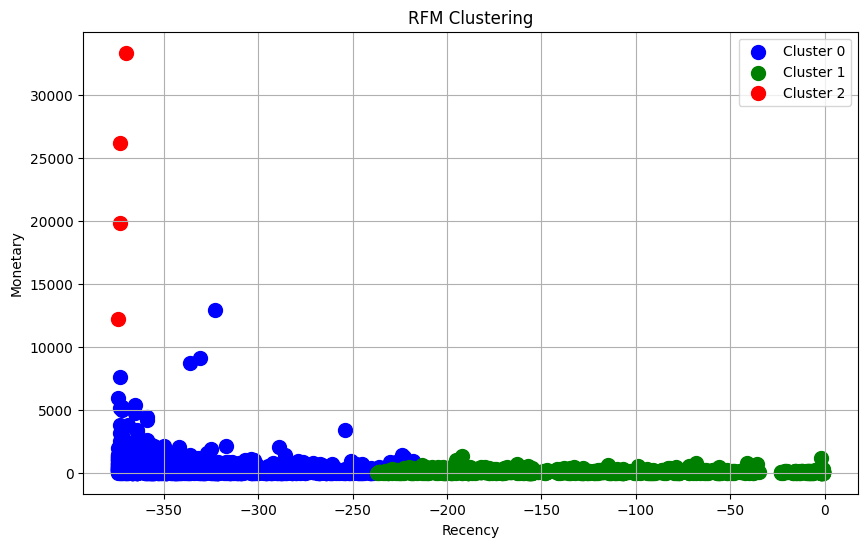

In [4]:
# Appliquer K-means avec le nombre optimal de clusters 
optimal_clusters = 3
# Initialiser K-means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Prédire les clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualiser les clusters
plt.figure(figsize=(10, 6))
# Définir les couleurs pour les clusters
colors = ['blue', 'green', 'red']
# Tracer chaque cluster
for cluster_num, color in zip(range(optimal_clusters), colors):
    cluster_data = rfm[rfm['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                color=color, s=100, label=f'Cluster {cluster_num}')

# Ajouter des labels et une légende
plt.title('RFM Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Analyser les clusters
cluster_analysis = rfm.groupby('Cluster').mean().reset_index()
print(cluster_analysis)

   Cluster    CustomerID     Recency    Frequency      Monetary
0        0  15283.464615 -333.342462   106.096615    321.357616
1        1  15350.755760 -127.709677    27.538249     95.867374
2        2  14899.000000 -372.500000  5807.750000  22893.065000


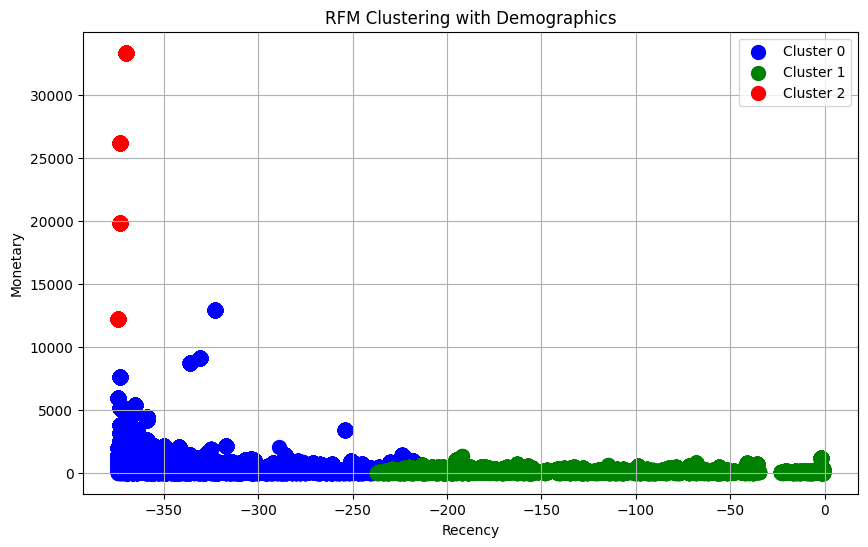

   Cluster     Recency    Frequency      Monetary         Country
0        0 -347.724002   349.826202    977.542379  United Kingdom
1        1 -137.189732    63.473443    202.782609  United Kingdom
2        2 -372.537816  6071.597219  22851.643193  United Kingdom


In [6]:
# Supposons que vous avez une colonne 'Country' dans votre dataframe initial
# Je vais supposer également que vous avez déjà calculé les clusters RFM et effectué le K-means

# Fusionner les données démographiques avec les résultats du clustering
rfm_with_demographics = pd.merge(
    rfm, positive_quantities[['CustomerID', 'Country']], on='CustomerID', how='left')

# Visualisation des clusters avec les données démographiques
plt.figure(figsize=(10, 6))

# Définir les couleurs pour les clusters
colors = ['blue', 'green', 'red']

# Tracer chaque cluster avec les données démographiques
for cluster_num, color in zip(range(optimal_clusters), colors):
    cluster_data = rfm_with_demographics[rfm_with_demographics['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                color=color, s=100, label=f'Cluster {cluster_num}')

# Ajouter des labels et une légende
plt.title('RFM Clustering with Demographics')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()
plt.grid(True)
plt.show()

# Analyser les clusters avec données démographiques
cluster_analysis_with_demographics = rfm_with_demographics.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Country': lambda x: x.mode()[0]  # Pays le plus fréquent par segment
}).reset_index()

print(cluster_analysis_with_demographics)

In [7]:
rfm_with_demographics.to_csv('rfm_with_demographics.csv', index=False)